# 🦒 Running Deep Learning Models with BioEngine ⚙️☁️

Welcome to this tutorial! We'll guide you through running image analysis models from [BioImage.IO](https://bioimage.io) using the BioEngine server.

We'll show you how to:
1. Load an image,
2. Reshape it according to each model's specifications (called `RDF` – a metadata format describing the models hosted on [BioImage.IO](https://bioimage.io)),
3. Send the image (as a numpy array) to the BioEngine server to run the models. 🚀

All models showcased are available in the [BioImage.IO Model Zoo](https://bioimage.io/#). You can also adapt this tutorial for other models in the zoo! 🧑‍🔬

⚠️ **Note:** The data will be sent to a remote server ([https://hypha.hypha.io](https://hypha.hypha.io)) run by the AI4Life team. This service is for evaluation purposes only and may change without notice. If you're looking for an on-prem solution (HPC or Kubernetes), check out the deployment guidelines here: [BioEngine Worker](https://github.com/aicell-lab/bioengine-worker/tree/bioengine-worker?tab=readme-ov-file#bioengine-worker).

If you're using your own instance, be sure to update the server URL (`https://hypha.hypha.io`) and the BioEngine service ID (`bioimage-io/bioengine-apps`) accordingly. 🔧

## Installation and module imports

In [ ]:
try:
    # For pyodide in the browser
    import micropip

    await micropip.install(["pyodide-http", "hypha-rpc", "kaibu-utils", "matplotlib"])

    # 2. Patch requests
    import pyodide_http

    pyodide_http.patch_all()  # Patch all libraries
except ImportError:
    # For native python with pip
    import subprocess

    subprocess.call(["pip", "install", "hypha-rpc", "kaibu-utils", "matplotlib"])

import json

import matplotlib.pyplot as plt
from hypha_rpc import connect_to_server, login
from kaibu_utils import fetch_image

# Server URL: For this demo we will use the hypha.aicell.io server
SERVER_URL = "https://hypha.aicell.io"

In [2]:
MODEL_ID = "discreet-rooster"

# Running UNet membrane segmentation model via the BioEngine

### Download an example image

Example image downloaded: (576, 720)


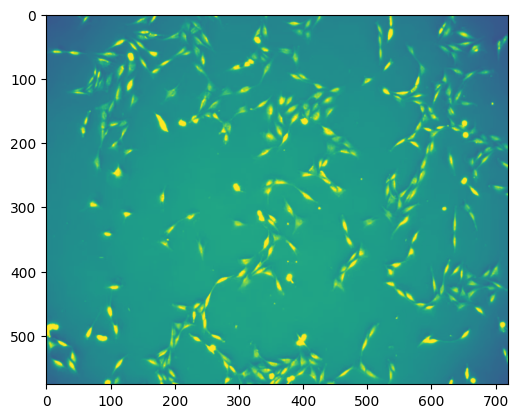

In [ ]:
# f"https://hypha.aicell.io/bioimage-io/artifacts/{MODEL_ID}/files/example_image.tiff"

image = await fetch_image(
    "https://raw.githubusercontent.com/aicell-lab/bioengine-worker/refs/heads/main/tests/example_image.tiff"
)
image = image.astype("float32")
print(f"Example image downloaded: {image.shape}")
plt.imshow(image)
plt.show()

### Connect to the server

In [11]:
token = await login({"server_url": SERVER_URL})
server = await connect_to_server(
    {"server_url": SERVER_URL, "token": token, "method_timeout": 3000}
)

Please open your browser and login at https://hypha.aicell.io/public/apps/hypha-login/?key=3nbaVodTpZFg3cZnmSCfuS


### Access the BioEngine deployments

A public BioEngine instance is available with the service ID `bioimage-io/bioengine-apps`

In [12]:
PUBLIC_BIOENGINE = "bioimage-io/bioengine-apps"

bioengine = await server.get_service(PUBLIC_BIOENGINE)

If you have started your own BioEngine instance, you can first list your deployment services and then 

In [13]:
services = await server.list_services({"type": "bioengine-apps"})

for service in services:
    print(f"BioEngine apps service ID: {service.id}")
    PRIVATE_BIOENGINE = service.id

if len(services) == 0:
    print(f"No BioEngine apps service available in workspace '{server.config.workspace}'.")

bioengine = await server.get_service(PRIVATE_BIOENGINE)

BioEngine apps service ID: ws-user-github|49943582/Y4rq5WkTPLfoRZmrCRqqMw:bioengine-apps


### View the RDF

This helps to verify the expected input format and other model details

In [14]:
model_rdf = await bioengine.bioimage_io_model_runner.get_model_rdf(model_id=MODEL_ID)

print(json.dumps(model_rdf, indent=4))

{
    "name": "Pancreatic Phase Contrast Cell Segmentation (U-Net)",
    "description": "DeepImageJ compatible U-Net trained to segment phase contrast microscopy images of pancreatic stem cells on a 2D polystyrene substrate.",
    "covers": [
        "example_image.png",
        "resultImage.png"
    ],
    "id_emoji": "\ud83d\udc13",
    "authors": [
        {
            "affiliation": "Ikerbasque EHU UPV",
            "email": null,
            "orcid": null,
            "name": "Ignacio Arganda Carreras",
            "github_user": null
        },
        {
            "affiliation": "EPFL, UC3M",
            "email": null,
            "orcid": null,
            "name": "DeepImageJ",
            "github_user": null
        }
    ],
    "attachments": {
        "files": [
            "U_Net_PhC_C2DL_PSC_segmentation.ipynb",
            "resultImage.tiff",
            "example_image.tiff",
            "binarize.ijm",
            "per_sample_scale_range.ijm"
        ]
    },
    "cite

### Make sure the input image shape is valid

In [16]:
# Get input format and reshape image accordingly
input_format = model_rdf["inputs"][0]
axes = input_format["axes"]  # "byxc"
min_shape = input_format["shape"]["min"]  # [1, 96, 96, 1]
step_shape = input_format["shape"]["step"]  # [0, 8, 8, 0]

print(f"Model expects axes: {axes}")
print(f"Minimum shape: {min_shape}")
print(f"Step requirements: {step_shape}")
print(f"Current image shape: {image.shape}")

# Ensure image meets minimum size requirements and step constraints
import numpy as np

# Current image is 2D (y, x), we need to make it 4D (b, y, x, c)
current_y, current_x = image.shape

# Check if current dimensions meet requirements
min_y, min_x = min_shape[1], min_shape[2]
step_y, step_x = step_shape[1], step_shape[2]

# Adjust dimensions if needed
target_y = max(min_y, current_y)
target_x = max(min_x, current_x)

# Make sure dimensions are compatible with step requirements
if step_y > 0:
    target_y = ((target_y - min_y) // step_y) * step_y + min_y
if step_x > 0:
    target_x = ((target_x - min_x) // step_x) * step_x + min_x

# Resize image if necessary
if current_y != target_y or current_x != target_x:
    from skimage.transform import resize
    image_resized = resize(image, (target_y, target_x), preserve_range=True).astype(np.float32)
    print(f"Resized image from {image.shape} to {image_resized.shape}")
else:
    image_resized = image

# Reshape to match expected format: (batch=1, y, x, channels=1)
image_formatted = image_resized[np.newaxis, :, :, np.newaxis]
print(f"Final image shape: {image_formatted.shape}")

# Update the image variable for use in subsequent cells
image = image_formatted

Model expects axes: byxc
Minimum shape: [1, 96, 96, 1]
Step requirements: [0, 8, 8, 0]
Current image shape: (576, 720)
Final image shape: (1, 576, 720, 1)


## Make prediction with the BioEngine

In [19]:
input_format = model_rdf["inputs"][0]
input_key = input_format["name"]
inputs = {input_key: image}

output_format = model_rdf["outputs"][0]
output_key = output_format["name"]

result = await bioengine.bioimage_io_model_runner.infer(
    model_id=MODEL_ID, inputs=inputs
)
mask = result[output_key]
print("prediction:", mask.shape)

prediction: (1, 576, 720, 1)


## Display the segmentation result

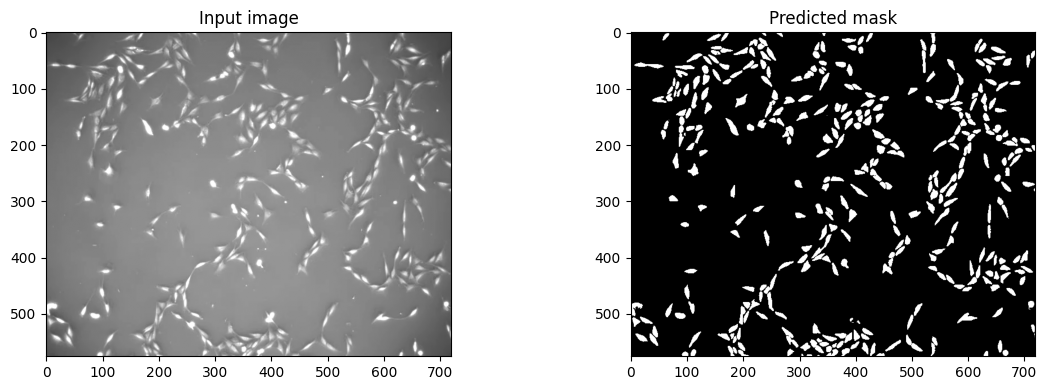

Input image shape (displayed): (576, 720)
Predicted mask shape (displayed): (576, 720)


In [21]:
# display the output
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Display input image - squeeze to remove batch and channel dimensions for display
input_display = image[0, :, :, 0]  # Remove batch and channel dims
ax1.imshow(input_display, cmap='gray')
ax1.set_title("Input image")

# Display predicted mask - squeeze to remove batch and channel dimensions
mask_display = mask[0, :, :, 0]  # Remove batch and channel dims
ax2.imshow(mask_display, cmap='gray')
ax2.set_title("Predicted mask")

plt.tight_layout()
plt.show()

print(f"Input image shape (displayed): {input_display.shape}")
print(f"Predicted mask shape (displayed): {mask_display.shape}")

## Trying more models in BioImage.IO

Feel free to find more models at https://dev.bioimage.io, if you want to run a model, please do the following as shown above:
 - Copy the animal nickname id in the model card
 - Print the RDF information so you know what's the expected input shape
 - Load your image, and make sure you reshape or resize it according to the expected input shape using numpy or scikit-image etc.
 - Run the model via `bioengine.bioimage_io_model_runner.infer()`, by passing the model id and image
 - Get the result, extract the image for display according to the output shape according to the RDF.


## Hosting your own BioEngine

While the above demos uses our public free BioEngine server, you can also launch your own bioengine server on a GPU workstation or HPC, and connect to your own BioEngine instance by switching the server URL. If you are interested please follow the deployment guidelines here: [BioEngine Worker](https://github.com/aicell-lab/bioengine-worker/tree/bioengine-worker?tab=readme-ov-file#bioengine-worker).

If you're using your own instance, be sure to update the server URL (`https://hypha.hypha.io`) and the BioEngine service ID (`bioimage-io/bioengine-apps`) accordingly. 🔧

Please note that the deployment is in early stage, so please if you have any issue or trouble in setting it up, please don't hesitate to reach out via email, forum, web form or github issues: https://github.com/bioimage-io/bioengine/issues

